# Two Gaussian curve alignment

This notebook showcases how `msalign` performs when dealing with multiple curves in the signal. 
The algorithm performs pretty well when aliging *clean* and *noisy* data, especially when the 
ratio of the two curves is the same (or very similar)

The algoritm is a little less capable when dealing with two curves and the alignment is performed 
towards the smaller curve.

In [1]:
import numpy as np
from scipy import signal
from scipy.signal.windows import gaussian
from scipy.ndimage import shift
import matplotlib.pyplot as plt
from msalign import Aligner

plt.style.use('ggplot')

# Utility functions
First, let's make a couple of functions that will generate data for us, as well as, show the results

In [2]:
def simple_two_gaussian_data(shifts, n_signals=5, n_points=100, noise=0):
    """Generate two-Gaussian signal that was shifted along the horizontal axis. 
    The proportion of the two conformations remains constant where the first conformation is 
    twice as large as the second
    """
    # generate x-axis
    x = np.arange(n_points)
    
    # generate Gaussian signal
    gaussian_one = gaussian(n_points, std=4)
    gaussian_two = shift(gaussian(n_points, std=4) * 0.5, n_points * 0.2)
    _gaussian = gaussian_one + gaussian_two
    peak = [gaussian_one.argmax(), gaussian_two.argmax()]
    
    # pre-allocate array
    array = np.zeros((n_signals, n_points))
    for i in range(n_signals):
        array[i] = shift(_gaussian, shifts[i]) + np.random.normal(0, noise, n_points)
        
    return x, array, shifts, peak

def variable_two_gaussian_data(shifts, n_signals=5, n_points=100, noise=0):
    """Generate two-Gaussian signal that was shifted along the horizontal axis. 
    The proportion of the two conformations remains constant where the first conformation is 
    twice as large as the second
    """
    # generate x-axis
    x = np.arange(n_points)
    gaussian_one_intensity = np.random.randint(1, 10, n_signals) / 10
    gaussian_two_intensity = np.random.randint(1, 10, n_signals) / 10
    
    # generate Gaussian signal
    gaussian_one = gaussian(n_points, std=4)
    gaussian_two = shift(gaussian(n_points, std=4), n_points * 0.2)
    peak = [gaussian_one.argmax(), gaussian_two.argmax()]
    
    # pre-allocate array
    array = np.zeros((n_signals, n_points))
    for i in range(n_signals):
        _gaussian = (gaussian_one * gaussian_one_intensity[i]) + (gaussian_two * gaussian_two_intensity[i])
        array[i] = shift(_gaussian, shifts[i]) + np.random.normal(0, noise, n_points)
        
    return x, array, shifts, peak

def overlay_plot(ax, x, array, peak):
    """Generate overlay plot, showing each signal and the alignment peak(s)"""
    for i, y in enumerate(array):
        y = (y / y.max()) + (i * 0.2)
        ax.plot(x, y, lw=3)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_xlabel("Index", fontsize=18)
    ax.set_xlim((x[0], x[-1]))
    ax.vlines(peak, *ax.get_ylim())
    
def shift_plot(ax, shift_in, shift_out):
    """Generate plot displaying the original shifts (before alignment) and corrected shifts (after alignment)"""
    ax.plot(shift_in, label="True shift", lw=3)
    ax.plot(shift_out, label="Computed shift", lw=3)
    ax.legend()
    
def difference_plot(ax, shift_in, shift_out):
    """Generate plot displaying the misalignment for each signal"""
    ax.plot(shift_out.flatten() - shift_in.flatten(), label="Difference", lw=3)
    ax.legend()
    
def align_and_plot(x, array, shifts_in, peak, **kwargs):
    """Align signals and plot the results"""
    # instantiate aligner object
    aligner = Aligner(
        x, 
        array, 
        peak, 
        return_shifts=True,
        align_by_index=True,
        only_shift=True,
        method="pchip",
        **kwargs
    )

    # align and collect data
    aligner.run()
    aligned_array, shifts_out = aligner.apply(return_shifts=True)

    # display before and after shifting
    fig, ax = plt.subplots(2, 2, figsize=(12, 10))
    overlay_plot(ax[0, 0], x, array, peak)
    overlay_plot(ax[1, 0], x, aligned_array, peak)
    shift_plot(ax[0, 1], shifts_in, shifts_out)
    difference_plot(ax[1, 1], shifts_in, shifts_out)

# Alignment of array with two *clean* Gaussians

Let's realign an array of two Gaussian signals back to the original position. Here, we have 10 signals, each was shifted by one bin to the right. We will be aligning along the horizontal dimension using two peaks (the apex of each Gaussian curve of the first curve).

After the alignment, we can also plot the shift correction determined by the `msalign` algorithm.

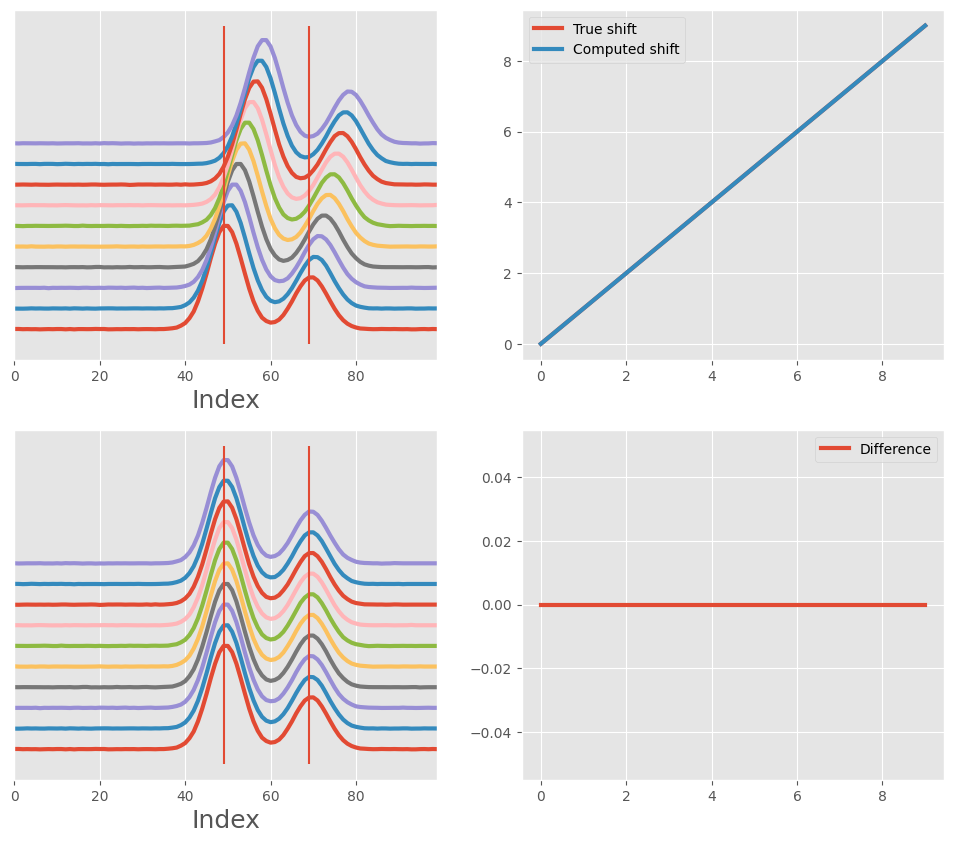

In [3]:
# generate data
x, array, shifts_in, peak = simple_two_gaussian_data(np.arange(10), n_signals=10, n_points=100, noise=1e-3)

# align and plot
align_and_plot(x, array, shifts_in, peak)

# Same array as before, but aligning using one peak (from the first Gaussian)

This does not pose much of a problem, since the intensity of the first curve is a lot higher than the second ones.

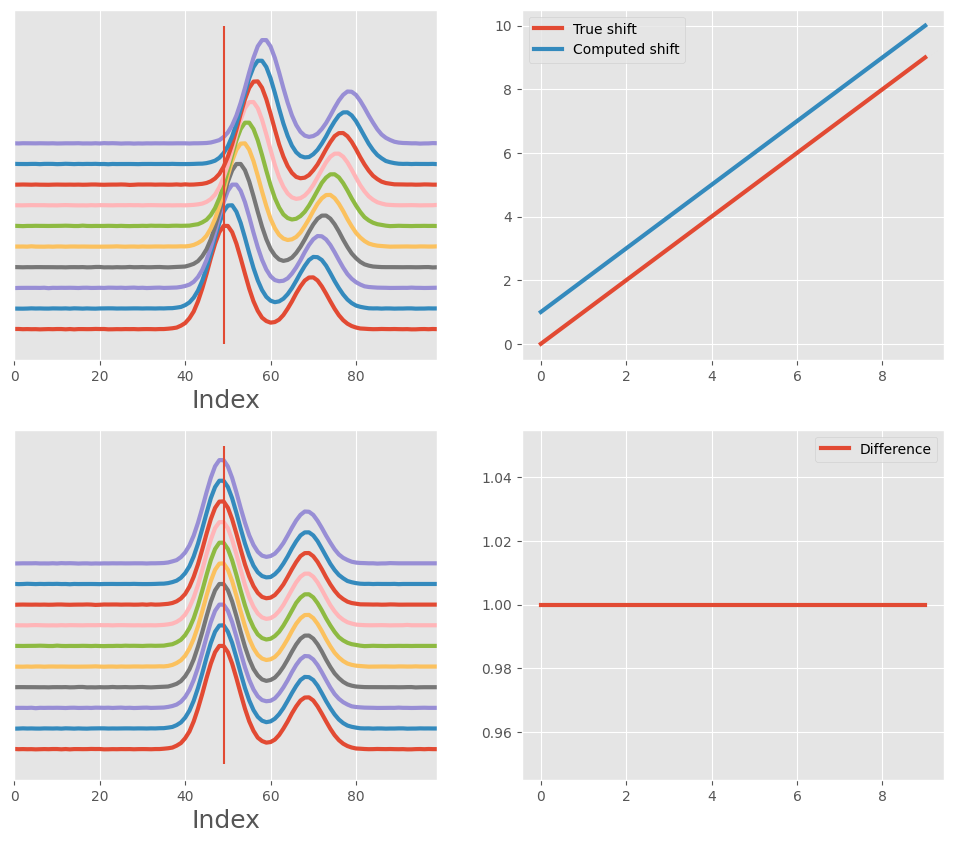

In [4]:
# align and plot
align_and_plot(x, array, shifts_in, [peak[0]])

# Same array as before, but aligning using one peak (from the second Gaussian)

This is a bit more problematic, because the algorithm will look at the maximum intensity of each curve and align
against it. Rather than aligning to the second curve, which is closer to the selected peak, it will shift the entire
array too far to the right.

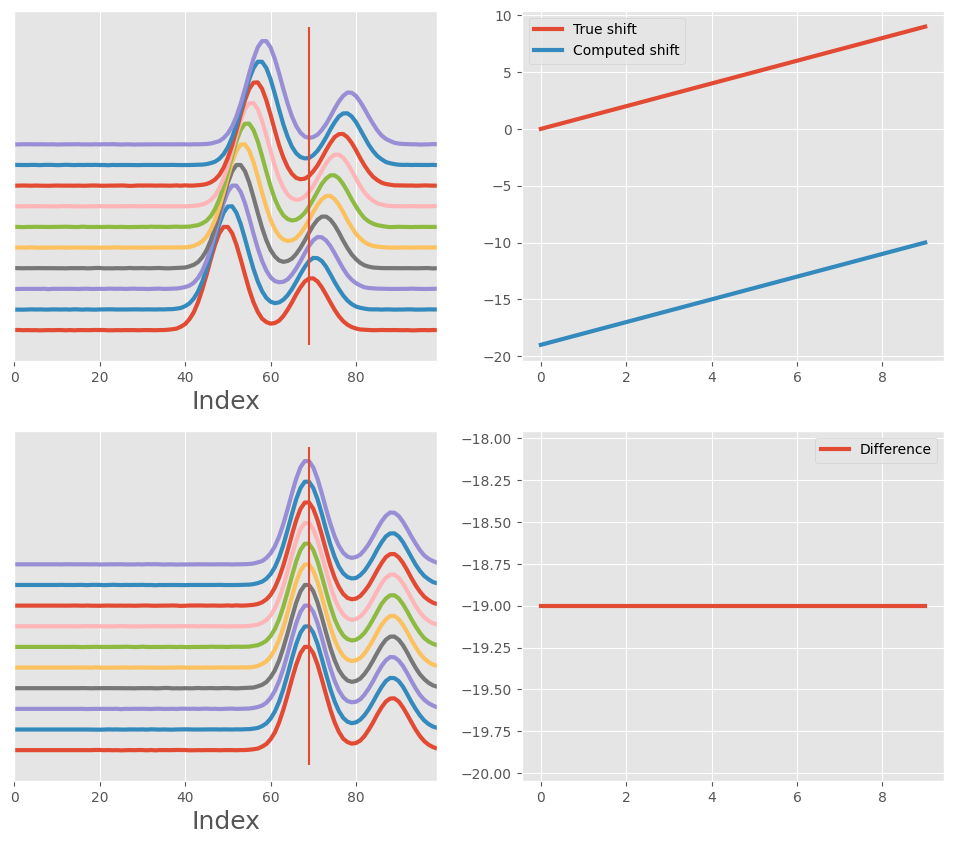

In [5]:
# align and plot
align_and_plot(x, array, shifts_in, [peak[1]])

# Alignment of array with two *very noisy* Gaussians

We use the same array but with quite a lot of noise. The algorithm deals with this quite well.

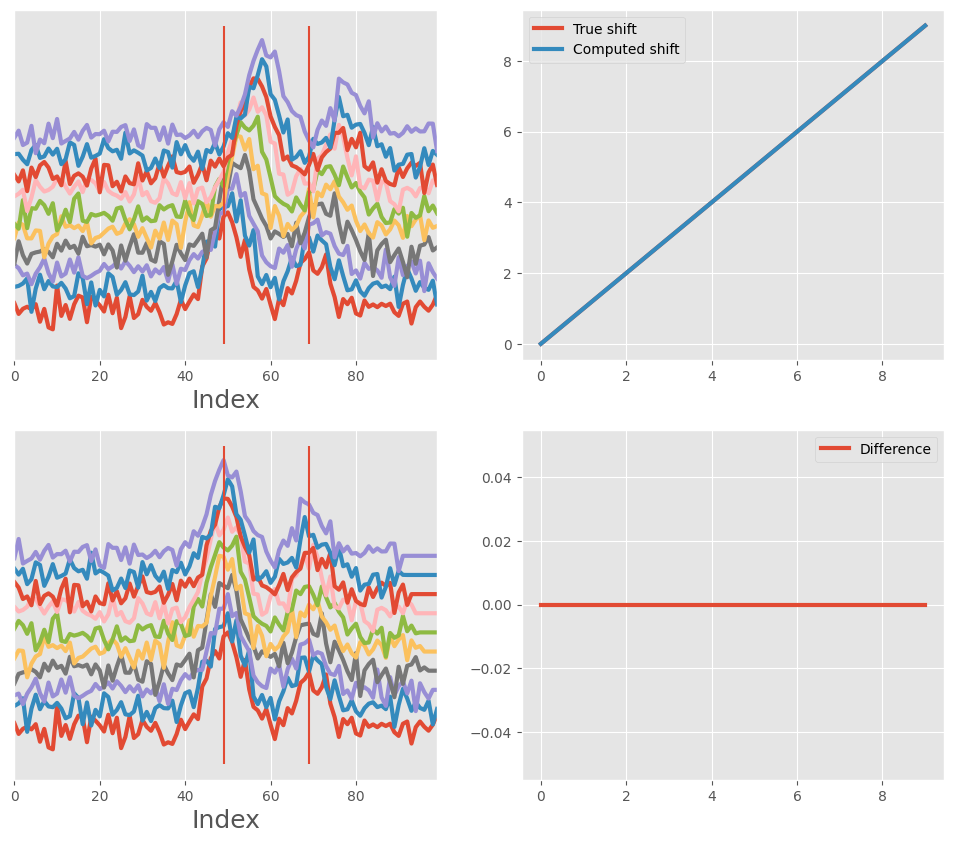

In [6]:
# generate data
x, array, shifts_in, peak = simple_two_gaussian_data(np.arange(10), n_signals=10, n_points=100, noise=1e-1)

# align and plot
align_and_plot(x, array, shifts_in, peak)

# Same as abovem but aligning against the first peak only

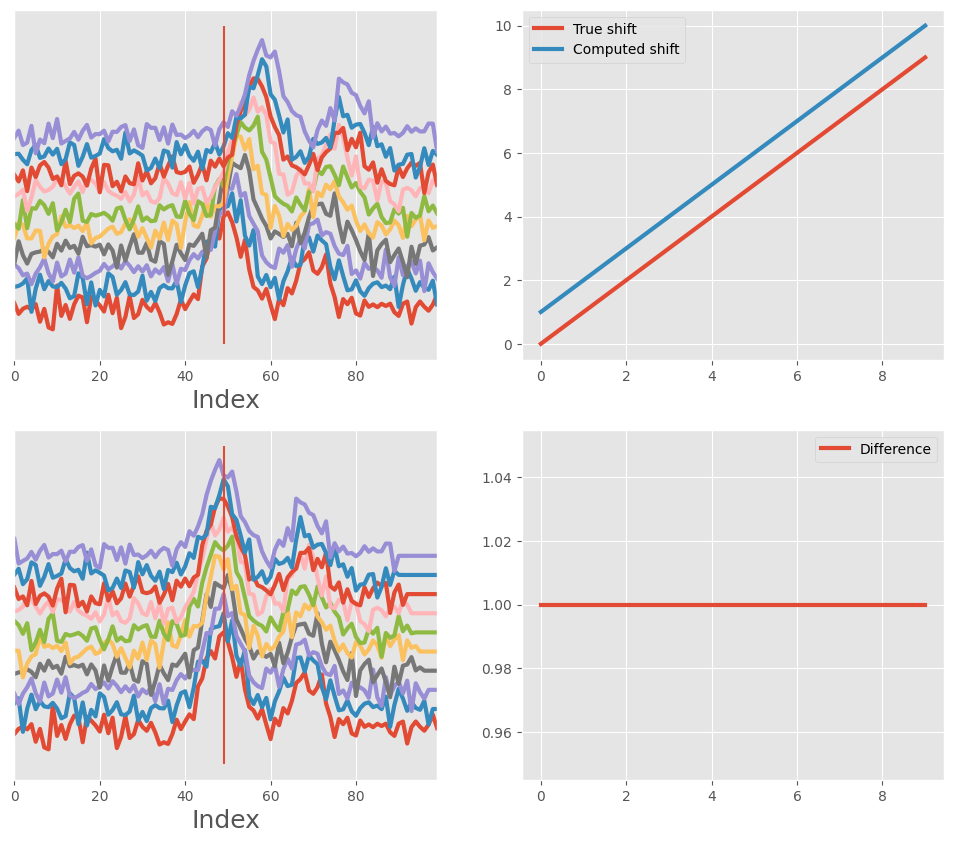

In [7]:
# align and plot
align_and_plot(x, array, shifts_in, [peak[0]])

# Alignment with two *clean* Gaussians - random shift

Here, we have two *clean* Gaussians that have been shifted left and right by some random number. We are aligning against peaks so the algorithm can do quite well.

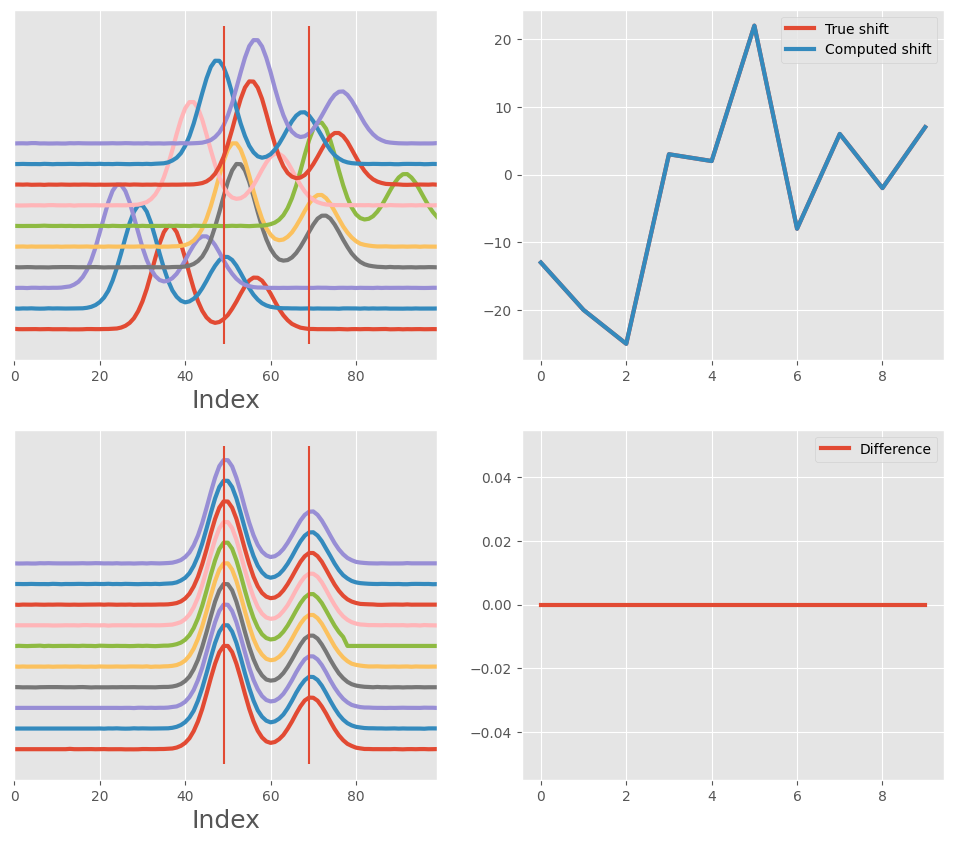

In [8]:
# generate artificial shift (simple offset of by for each signal)
np.random.seed(15)  # make sure we get reproducible results
shifts_in = np.random.randint(-25, 40, 10)

# generate data
x, array, shifts_in, peak = simple_two_gaussian_data(shifts_in, n_signals=10, n_points=100, noise=1e-3)

# align and plot
align_and_plot(x, array, shifts_in, peak)

# Alignment of two *random* Gaussians

Here, we are aligning two Gaussians, however, the intensity of each Gaussian is not constant. 
The algorithm performs reasonably well when aligning using two peaks.

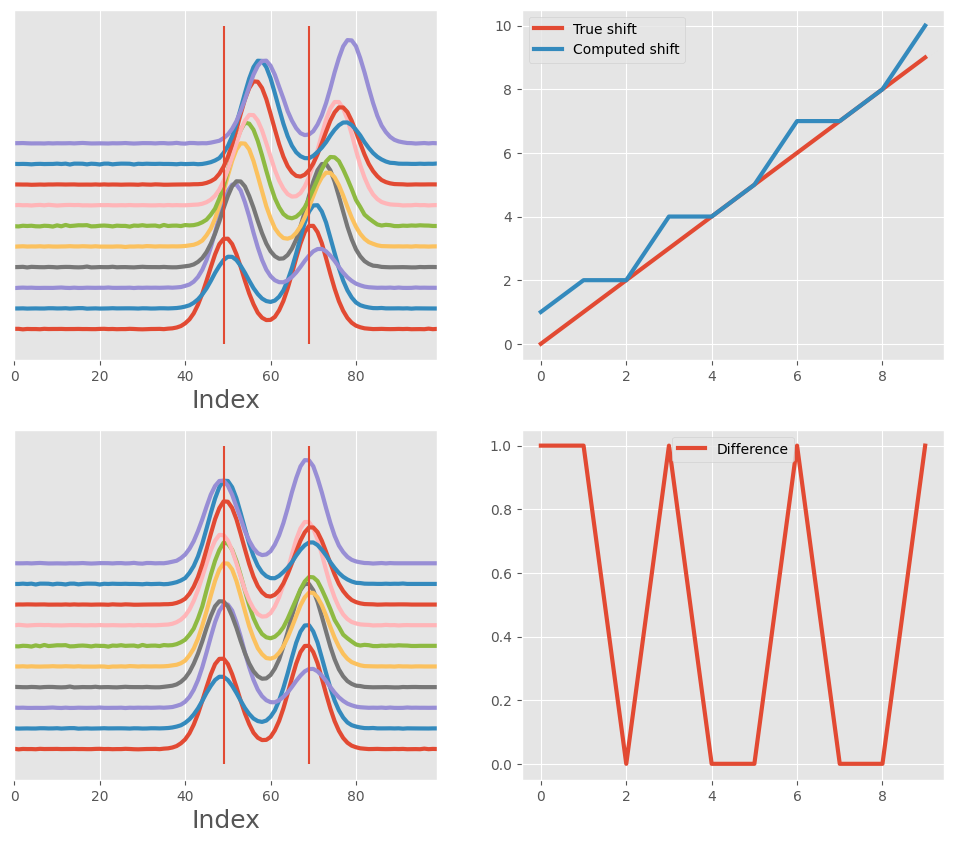

In [9]:
# generate artificial shift (simple offset of by for each signal)
np.random.seed(42)
shifts_in = np.arange(10)

# generate data
x, array, shifts_in, peak = variable_two_gaussian_data(shifts_in, n_signals=10, n_points=100, noise=1e-3)

# align and plot
align_and_plot(x, array, shifts_in, peak)

# Same as above, but using single peak

In cases like this, alignment using single peak will not work particularly well since the algorithm
will try to align against the most dominant peak (rather than the closest peak). If possible, provide
as many anchor points as you can.

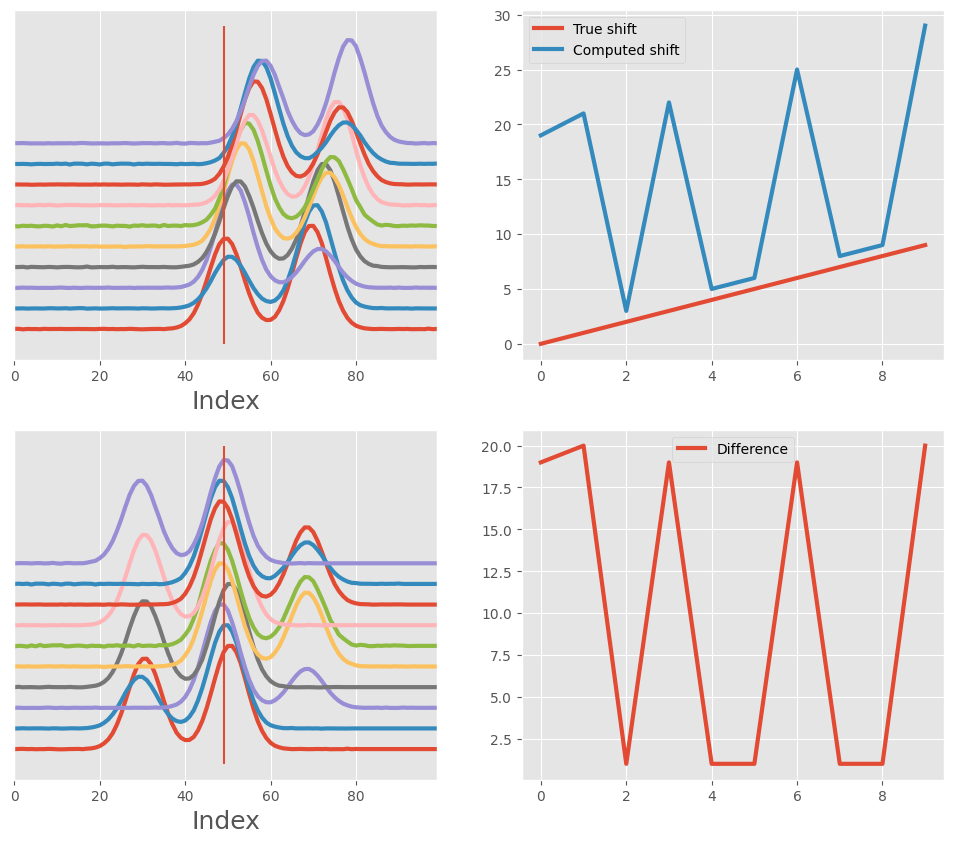

In [10]:
# align and plot
align_and_plot(x, array, shifts_in, [peak[0]])